In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os, sys
import pandas as pd

sys.path.append("..")
from functions import build_vocab, encode_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
import re
from collections import Counter
import re


def clean_text(text):
    text = text.lower().strip()  # Lowercase and strip whitespaces
    # Keep only 2 consecutive same characters
    text = re.sub(r'(.)\1+', r'\1\1', text)
    # Remove all . , and :
    text = re.sub(r'[.,:]', '', text)
    return text

# Tokenize the text
def tokenize_text(text):
    return text.split()

def build_vocab(texts):
    tokenized_texts = [tokenize_text(clean_text(text)) for text in texts]
    all_words = [word for text in tokenized_texts for word in text if not ('https' in word or any(char.isalnum() == False for char in word))]
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    
    # Keep only the 1000 most frequent words
    top_1000_words = sorted_words[:1000]
    
    # Create a mapping from word to index
    word_to_idx = {word: idx+1 for idx, word in enumerate(top_1000_words)}
    word_to_idx['<PAD>'] = 0  # Padding index
    word_to_idx['<UNK>'] = len(word_to_idx)  # Unknown word token
    return word_to_idx, tokenized_texts

def is_illegal_word(word):
    return 'https' in word or any(char.isalnum() == False for char in word) or word not in word_to_idx

def encode_sequences(tokenized_texts, word_to_idx, seq_length=6):
    sequences = []
    for tokens in tokenized_texts:
        if len(tokens) < seq_length:
            continue
        for i in range(seq_length, len(tokens)):
            seq = tokens[i-seq_length:i]  # Input sequence of words
            target = tokens[i]  # Target word (next word)
            if any(is_illegal_word(word) for word in seq) or is_illegal_word(target):
                continue
            encoded_seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in seq]
            encoded_target = word_to_idx.get(target, word_to_idx['<UNK>'])
            sequences.append((encoded_seq, encoded_target))
    return sequences

# Create custom Dataset
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target)

# Define GRU model
class NextWordGRU(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_prob=0.3):
        super(NextWordGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        gru_out = self.dropout(gru_out[:, -1, :])   # Take the output of the last GRU cell
        out = self.fc(gru_out)
        return out

def validate_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  # No need to track gradients during validation
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()  # Set model to training mode

        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Calculate average loss for the epoch
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate the model
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Log epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            best_model = model  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Use the best model for prediction
    model = best_model

  

    return train_losses, val_losses, val_accuracies

# Predict the next word
def predict_next_word(model, sequence, word_to_idx, idx_to_word):
    model.eval()
    sequence = torch.tensor(sequence).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(sequence)
        predicted_idx = torch.argmax(output, dim=1).item()
    return idx_to_word[predicted_idx]

def get_first_csv_file(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {folder_path}")
    return os.path.join(folder_path, csv_files[0])

# Read data from the first x CSV files in the 'x' folder
folder_path = '../../data/x'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:3]  # Take the first x files

dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Assuming the CSV has a 'text' column. Adjust if the column name is different.
texts = df['text'].tolist()

print(f"Loaded {len(texts)} text samples from CSV.")

# Preprocess and tokenize
word_to_idx, tokenized_texts = build_vocab(texts)
sequences = encode_sequences(tokenized_texts, word_to_idx, seq_length=4)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of sequences: {len(sequences)}")


Loaded 30000 text samples from CSV.
Vocabulary size: 1002
Number of sequences: 68239


In [25]:
from sklearn.model_selection import train_test_split

# Split sequences into training and validation sets (80% train, 20% validation)
train_sequences, val_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Create DataLoader for training and validation data
train_dataset = TextDataset(train_sequences)
val_dataset = TextDataset(val_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Define the model, loss function, and optimizer
vocab_size = len(word_to_idx)
embed_size = 128
hidden_size = 256
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

model = NextWordGRU(vocab_size, embed_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting model training...")

# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Using device: cpu
Starting model training...
Epoch [1/10] completed, Average Train Loss: 5.1151, Validation Loss: 4.6964, Validation Accuracy: 0.1493
Epoch [2/10] completed, Average Train Loss: 4.4627, Validation Loss: 4.5197, Validation Accuracy: 0.1668
Epoch [3/10] completed, Average Train Loss: 4.0889, Validation Loss: 4.4785, Validation Accuracy: 0.1771
Epoch [4/10] completed, Average Train Loss: 3.7330, Validation Loss: 4.5120, Validation Accuracy: 0.1805
Epoch [5/10] completed, Average Train Loss: 3.3618, Validation Loss: 4.6055, Validation Accuracy: 0.1806
Epoch [6/10] completed, Average Train Loss: 2.9939, Validation Loss: 4.7446, Validation Accuracy: 0.1741
Early stopping triggered


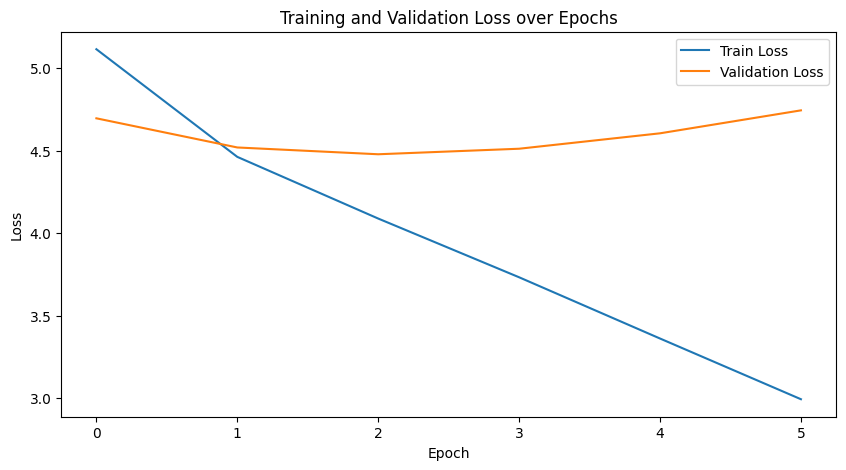

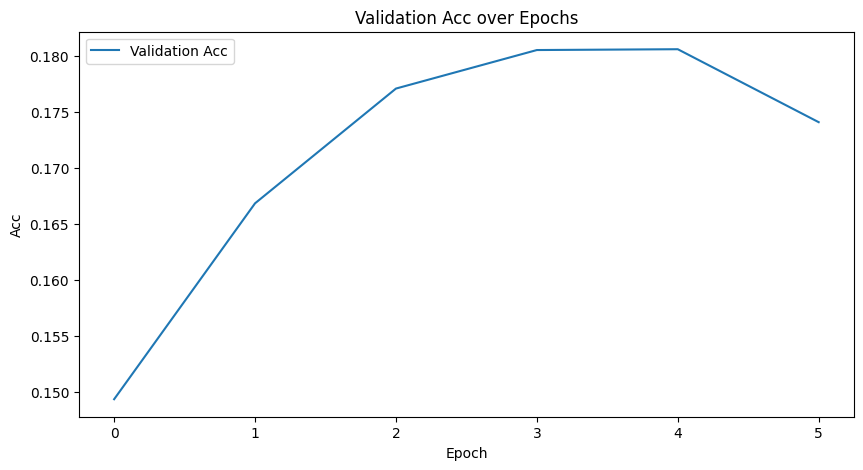

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("Validation Acc over Epochs")
plt.legend()
plt.show()

In [27]:
import json

# Save the vocabulary (word_to_idx dictionary)
vocab_save_path = 'vocabulary.json'
with open(vocab_save_path, 'w') as f:
    json.dump(word_to_idx, f)
print(f"Vocabulary saved to {vocab_save_path}")

#save model
model_save_path = 'model.pth'
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Vocabulary saved to vocabulary.json
Model saved to model.pth


In [28]:
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

indata = [word_to_idx[words] for words in "hello how are".split()]
print(predict_next_word(model, indata, word_to_idx, idx_to_word))

you


In [29]:
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

for i in range(100):
    sequence, target = val_dataset[i+1000]
    sequence_words = [idx_to_word[idx.item()] for idx in sequence]
    target_word = idx_to_word[target.item()]
    print(f"Sequence {i + 1}: {' '.join(sequence_words)} -> {target_word}")

Sequence 1: is going to rain -> i
Sequence 2: so i could watch -> the
Sequence 3: feeling worse than yesterday -> it
Sequence 4: thinking of a name -> for
Sequence 5: an answer to a -> question
Sequence 6: bad night 4 him -> bad
Sequence 7: soo busy right now -> have
Sequence 8: never ever stay up -> late
Sequence 9: weird but i like -> it
Sequence 10: right now is to -> be
Sequence 11: be fair in the -> photos
Sequence 12: we the only school -> in
Sequence 13: if you need help -> i
Sequence 14: be at work by -> 9
Sequence 15: find anything to watch -> any
Sequence 16: nothing much just watched -> a
Sequence 17: gonna be a long -> night
Sequence 18: to come back to -> work
Sequence 19: aww put your feet -> up
Sequence 20: it i really hate -> waking
Sequence 21: i want to go -> to
Sequence 22: a good day 2 -> twitter
Sequence 23: game we made up -> that
Sequence 24: on this at work -> cause
Sequence 25: the way home but -> you
Sequence 26: i cant seem to -> find
Sequence 27: feet are ki